# Introduction to spiking neurons

Spiking neural networks are considered to be the *third generation* of neural networks, preceeded by McCulloch-Pitts threshold neurons ("first generation") which produced digital outputs and Artificial Neural Networks with continuous activations, like sigmoids and hyperbolic tangets, ("second generation") that are commonly used these days.


In [2]:
# - Install requirements
!pip install numpy torch matplotlib

In [120]:
# - Required imports
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300
plt.rcParams["image.cmap"] = 'Greys'

## Artificial Neuron (AN) Model

The standard artificial neuron model used most commonly in ANNs and DNNs is a simple equation

$\vec{y} = \Theta(W.\vec{x} + b)$

where $\Theta$ is typically a non linear activation function such as a *ReLU*, *sigmoid* or *hyperbolic tangent* function.

<div>
    <img src="https://raw.githubusercontent.com/ai-cortex/snn-workshop-amld-2020/master/Notebooks/1_IntroToSNNs/AN-neuron.png" width = 30%/>
</div> 

In [121]:
# - Define a forward function for an ANN with a `ReLU` transfer function
#   Arguments:
#     x - vector of inputs (Nbatches, Nsamples, Nin,)
#     W - weight matrix (Nin, Nout)
#     b - Bias input vector (Nout,)
def forward_ann(x, W, b):
    # - Compute x matmul W
    #   Add bias vector
    #   Compute and return ReLU of result (Hint: `torch.clamp`)
    return torch.clamp(x @ W + b, 0., None)

In [122]:
# - Generate some random input data to test with
n_batches = 3
n_samples = 100
Nin = 5
Nout = 3
input_data = torch.randn((n_batches, n_samples, Nin))

# - Generate a random configuration to W and b
W = torch.randn((Nin, Nout)) / np.sqrt(Nin)
b = torch.rand((Nout,)) / np.sqrt(Nin)

In [123]:
# - Test your forward function
y = forward_ann(input_data, W, b)

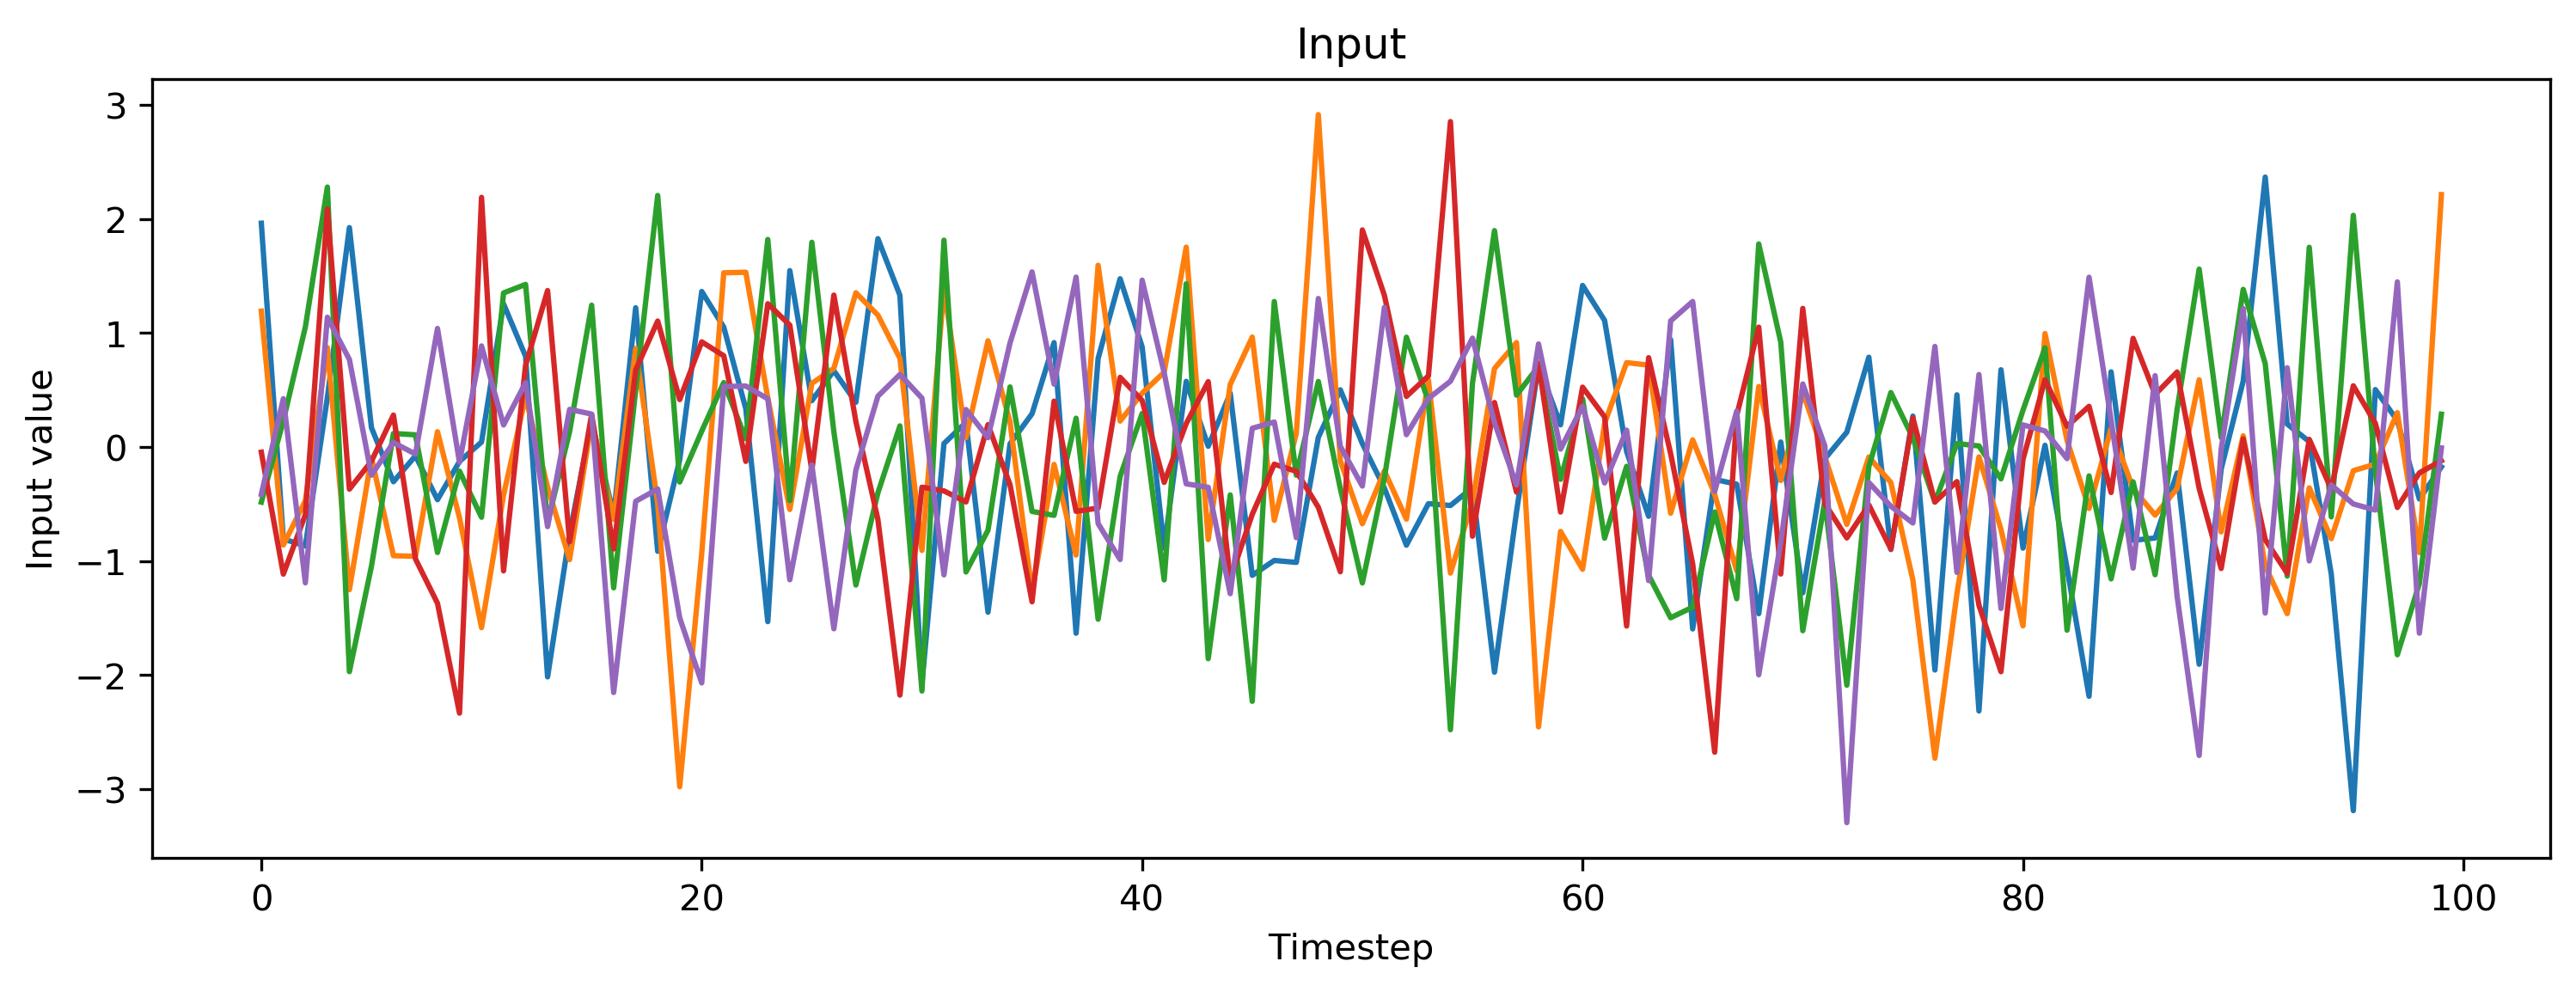

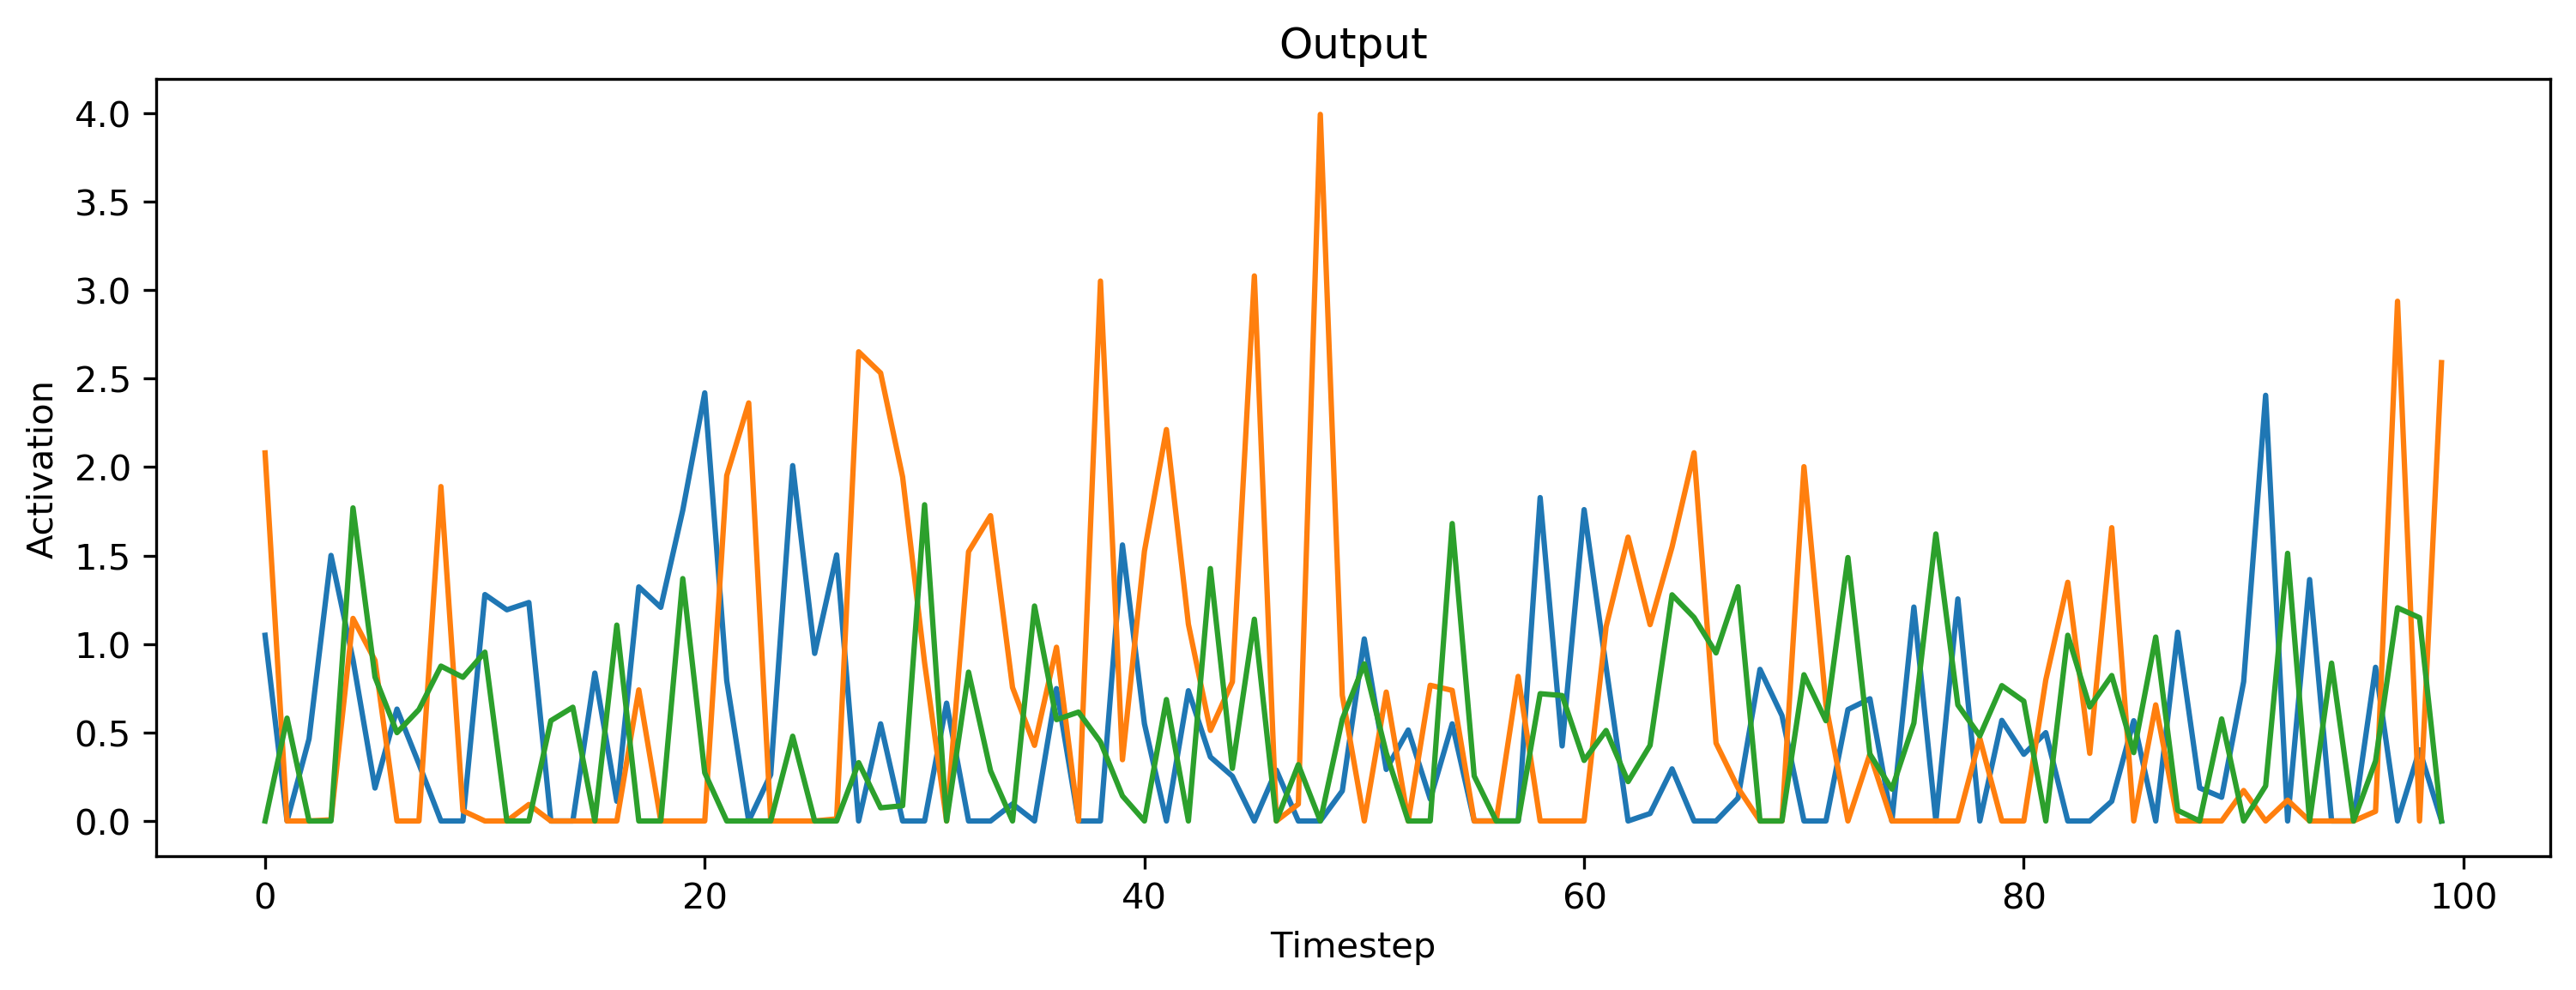

In [124]:
plt.plot(input_data[0])
plt.xlabel('Timestep')
plt.ylabel('Input value')
plt.title('Input')

plt.figure()
plt.plot(y[0]);
plt.xlabel('Timestep')
plt.ylabel('Activation')
plt.title('Output');

**Note that the output depends only on the instantaneous inputs. The neuron does not have an internal state that would affect its output.**

This is where spiking neurons and spiking neural networks (SNNs) come into play. They add an additional dependence on the current state of the neuron, and include explicit temporal dynamics. They also communicate with each other using pulsed events called "spikes".

# NEED A DIAGRAM OF IAF MODEL

Internal state

Communicate with binary events, rather than floating-point values

# Building upon our knowledge of ANNs

Given our current knowledge and understanding of ANNs, can we kickstart the use of spiking neural networks? Ofcourse the answer is yes. We will go about this in two steps:

1. Simplify the neuron model.
2. Interpret this model in terms of activation functions.

## Including neural state — Integrate and Fire (IAF) model

Now we take a step to introduce some understanding of temporal inputs. We do that by including an internal neuron state which evolves over time, with integer time-steps denoted as $t$. Let's call this $v_t$; the internal state at time $t$.

The update function will be to accumulate the input into $v$:

$$v_{t+1} = v_t + Wx + b$$

We also choose a transfer function that produces events — basically, if the internal state is above a threshold $\theta$, the neuron produces a binary event on the output. We'll use a Heaviside function for that.

$$y = H(v, \theta) = v > \theta$$

When a neuron sends an output, we reset $v$ by subtracting the threshold:

$$v = v - y * \theta$$

In [125]:
# - Define a forward function for an IAF spiking neuron
#   Arguments:
#   x - Input (Nbatches, Nsamples, Nin)
#   W - Weights (Nin, Nout)
#   b - Bias vector (Nout,)
#   theta - Threshold ()
def forward_iaf(x, W, b, theta):
    # - Here we obtain the shapes of the IAF layer and input
    Nbatches, Nsamples, Nin = x.shape
    _, Nout = W.shape
    
    # - Initialise the internal state record of the layer (Nout, )
    v = torch.zeros((Nout,))
    
    # - Initialise the output tensors to return
    vs = torch.empty(Nbatches, Nsamples, Nout)
    ys = torch.empty(Nbatches, Nsamples, Nout)
    
    # - Define the transfer function
    def H(v, theta):
        return v > theta
    
    # - Loop over time-steps
    for t in range(Nsamples):
        # - Accumulate input into the internal state (hint — same as for the ANN)
        v = v + x[:, t, :] @ W + b
        
        # - Determine output by using transfer function H()
        y = H(v, theta)
        
        # - Reset spiking neurons
        v = v - y * theta
        
        # - Record state and output to return
        vs[:, t, :] = v
        ys[:, t, :] = y
        
    # - Return output
    return ys, vs

Now we need to define some input. Since we are operating in spiking land, we will generation "Poisson" random spike trains for input.

In [126]:
# - Define layer size and parameters
Nin = 8
Nout = 2

W = torch.rand((Nin, Nout)) / Nin
b = 0.001 * torch.ones((Nout,))
theta = 1.

# - Define some random input
Nbatches = 1
Nsamples = 1000
spike_rate = 0.01

input_spikes = (torch.rand((Nbatches, Nsamples, Nin)) < spike_rate).float()

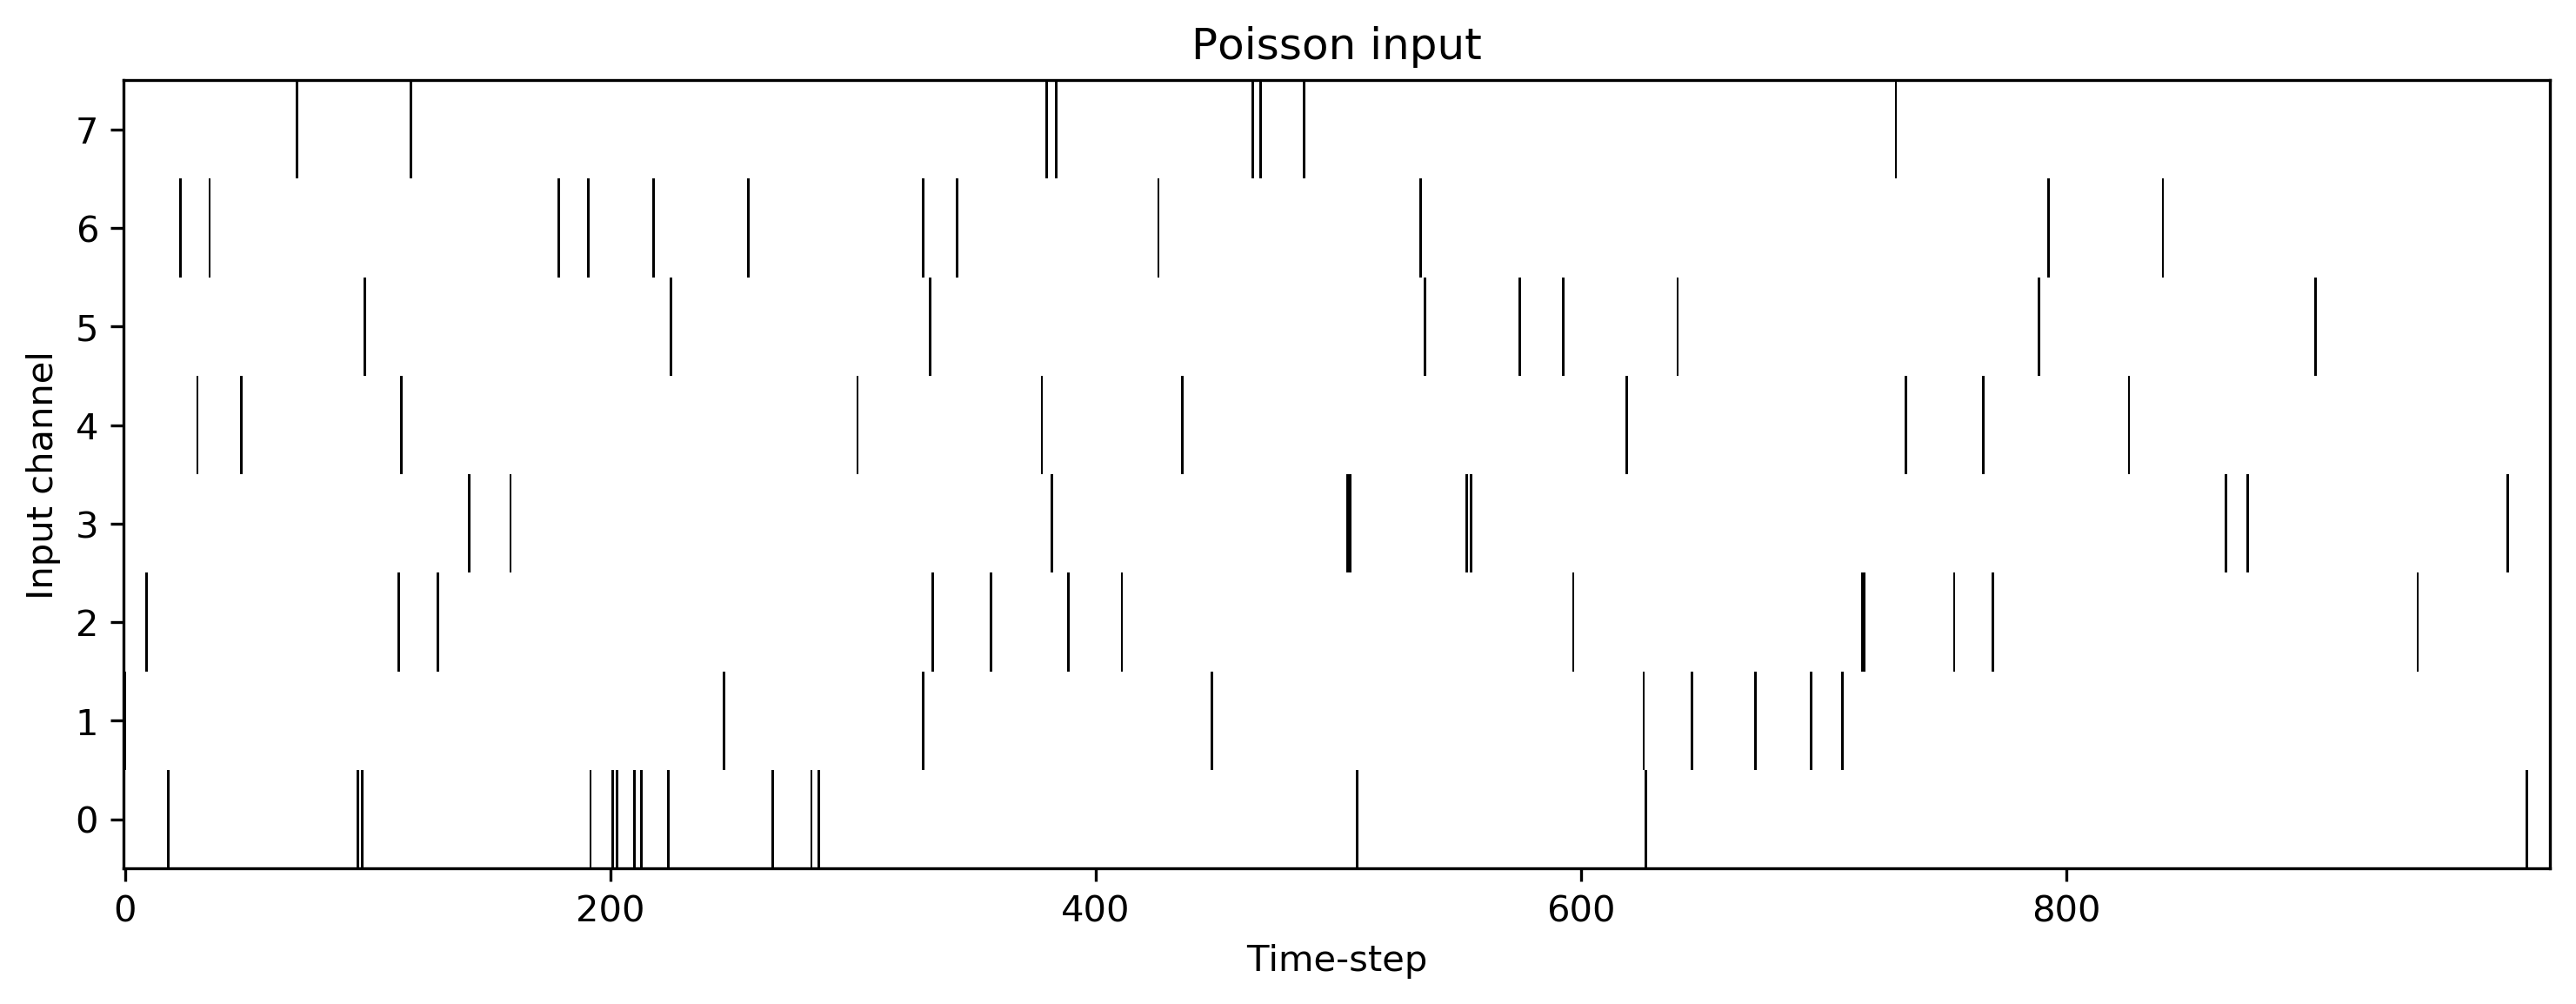

In [127]:
plt.imshow(input_spikes[0].T, aspect = 'auto', origin = 'lower');
plt.xlabel('Time-step')
plt.ylabel('Input channel')
plt.title('Poisson input');

In [128]:
# - Evaluate the spiking neuron over the input
ys, vs = forward_iaf(input_spikes, W, b, theta)

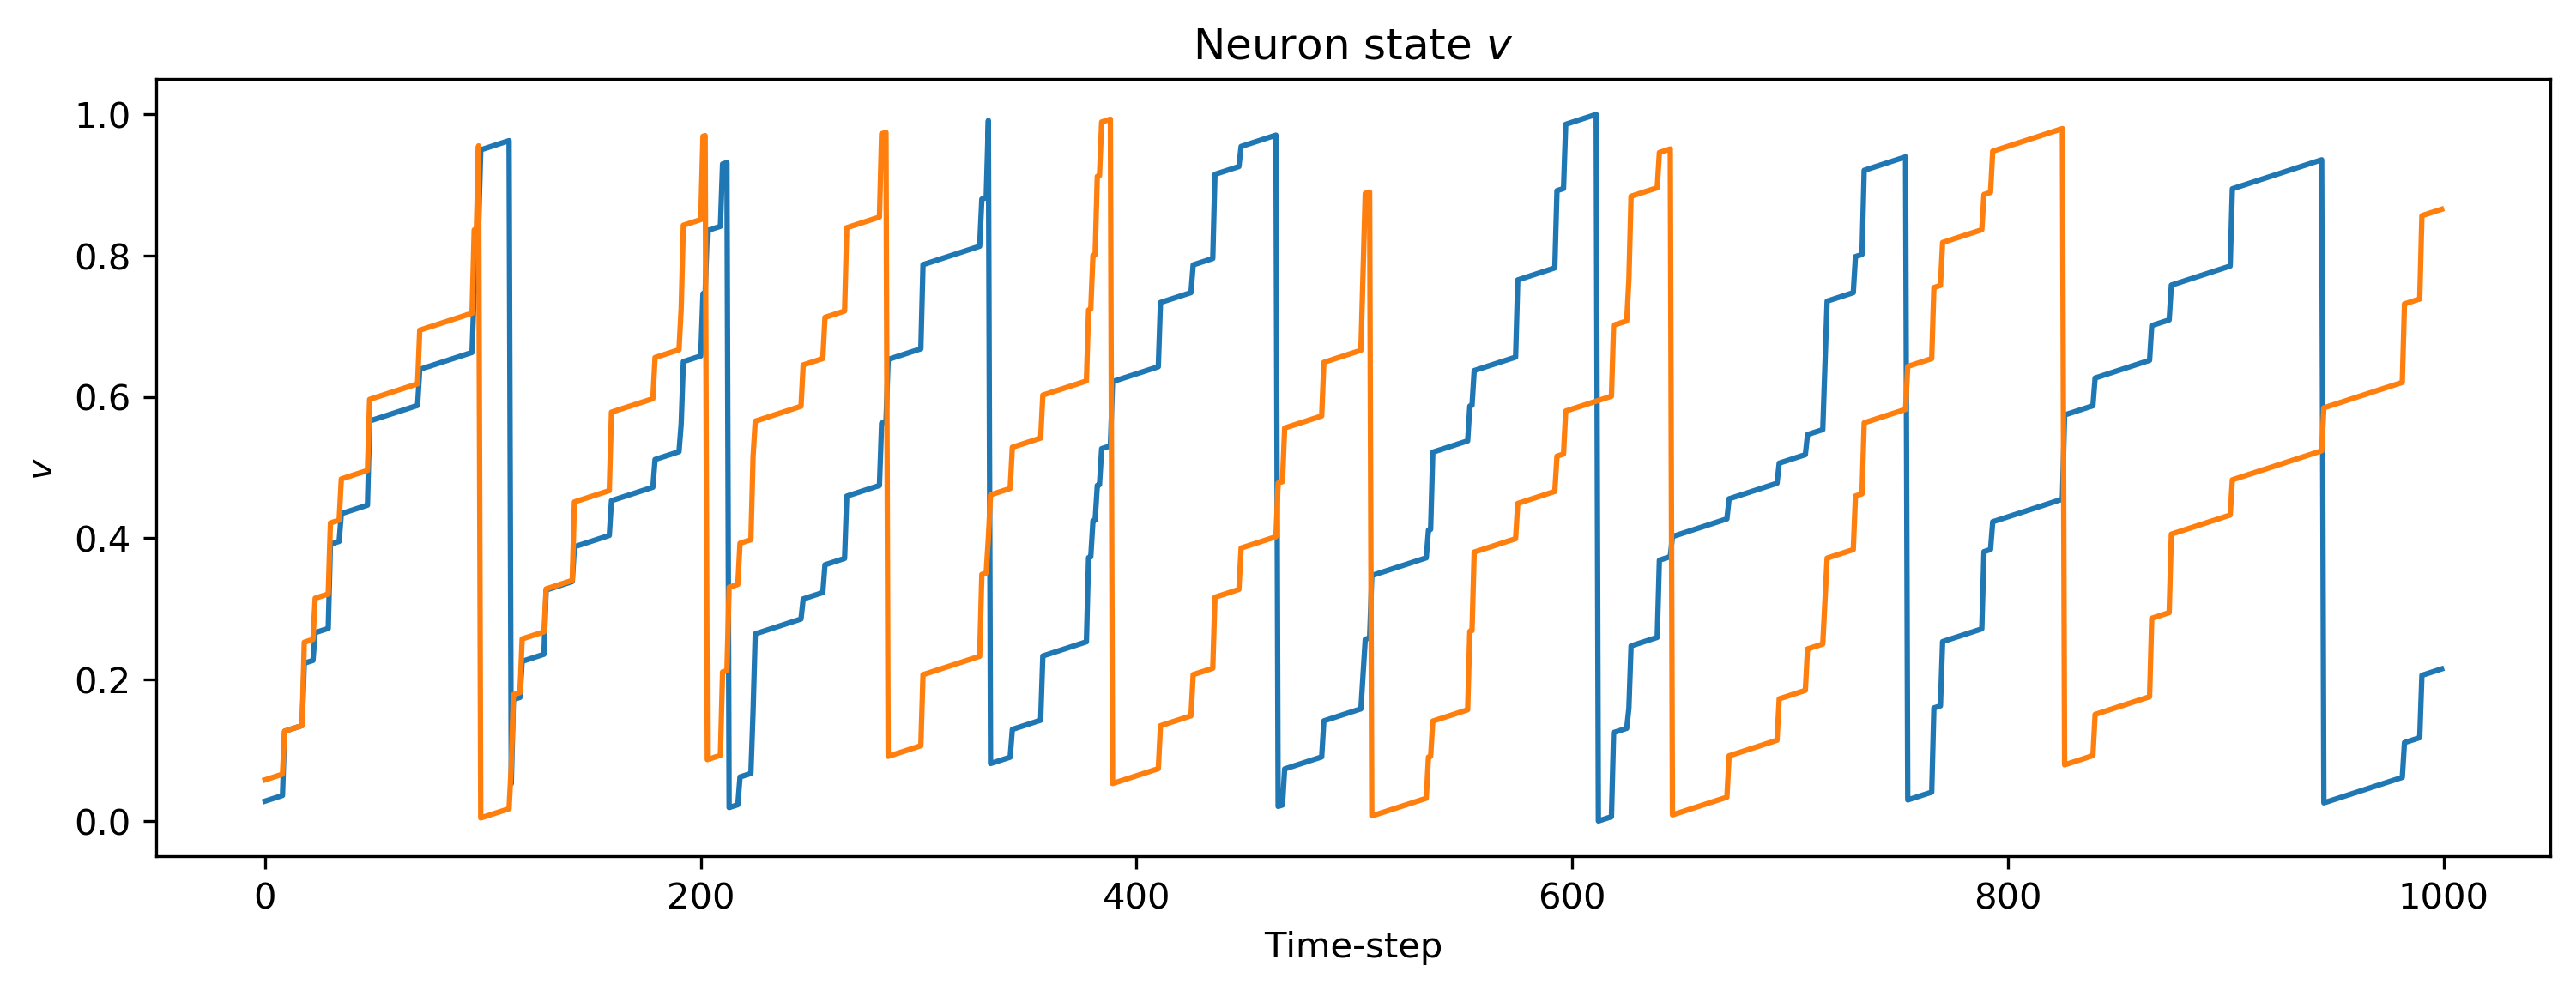

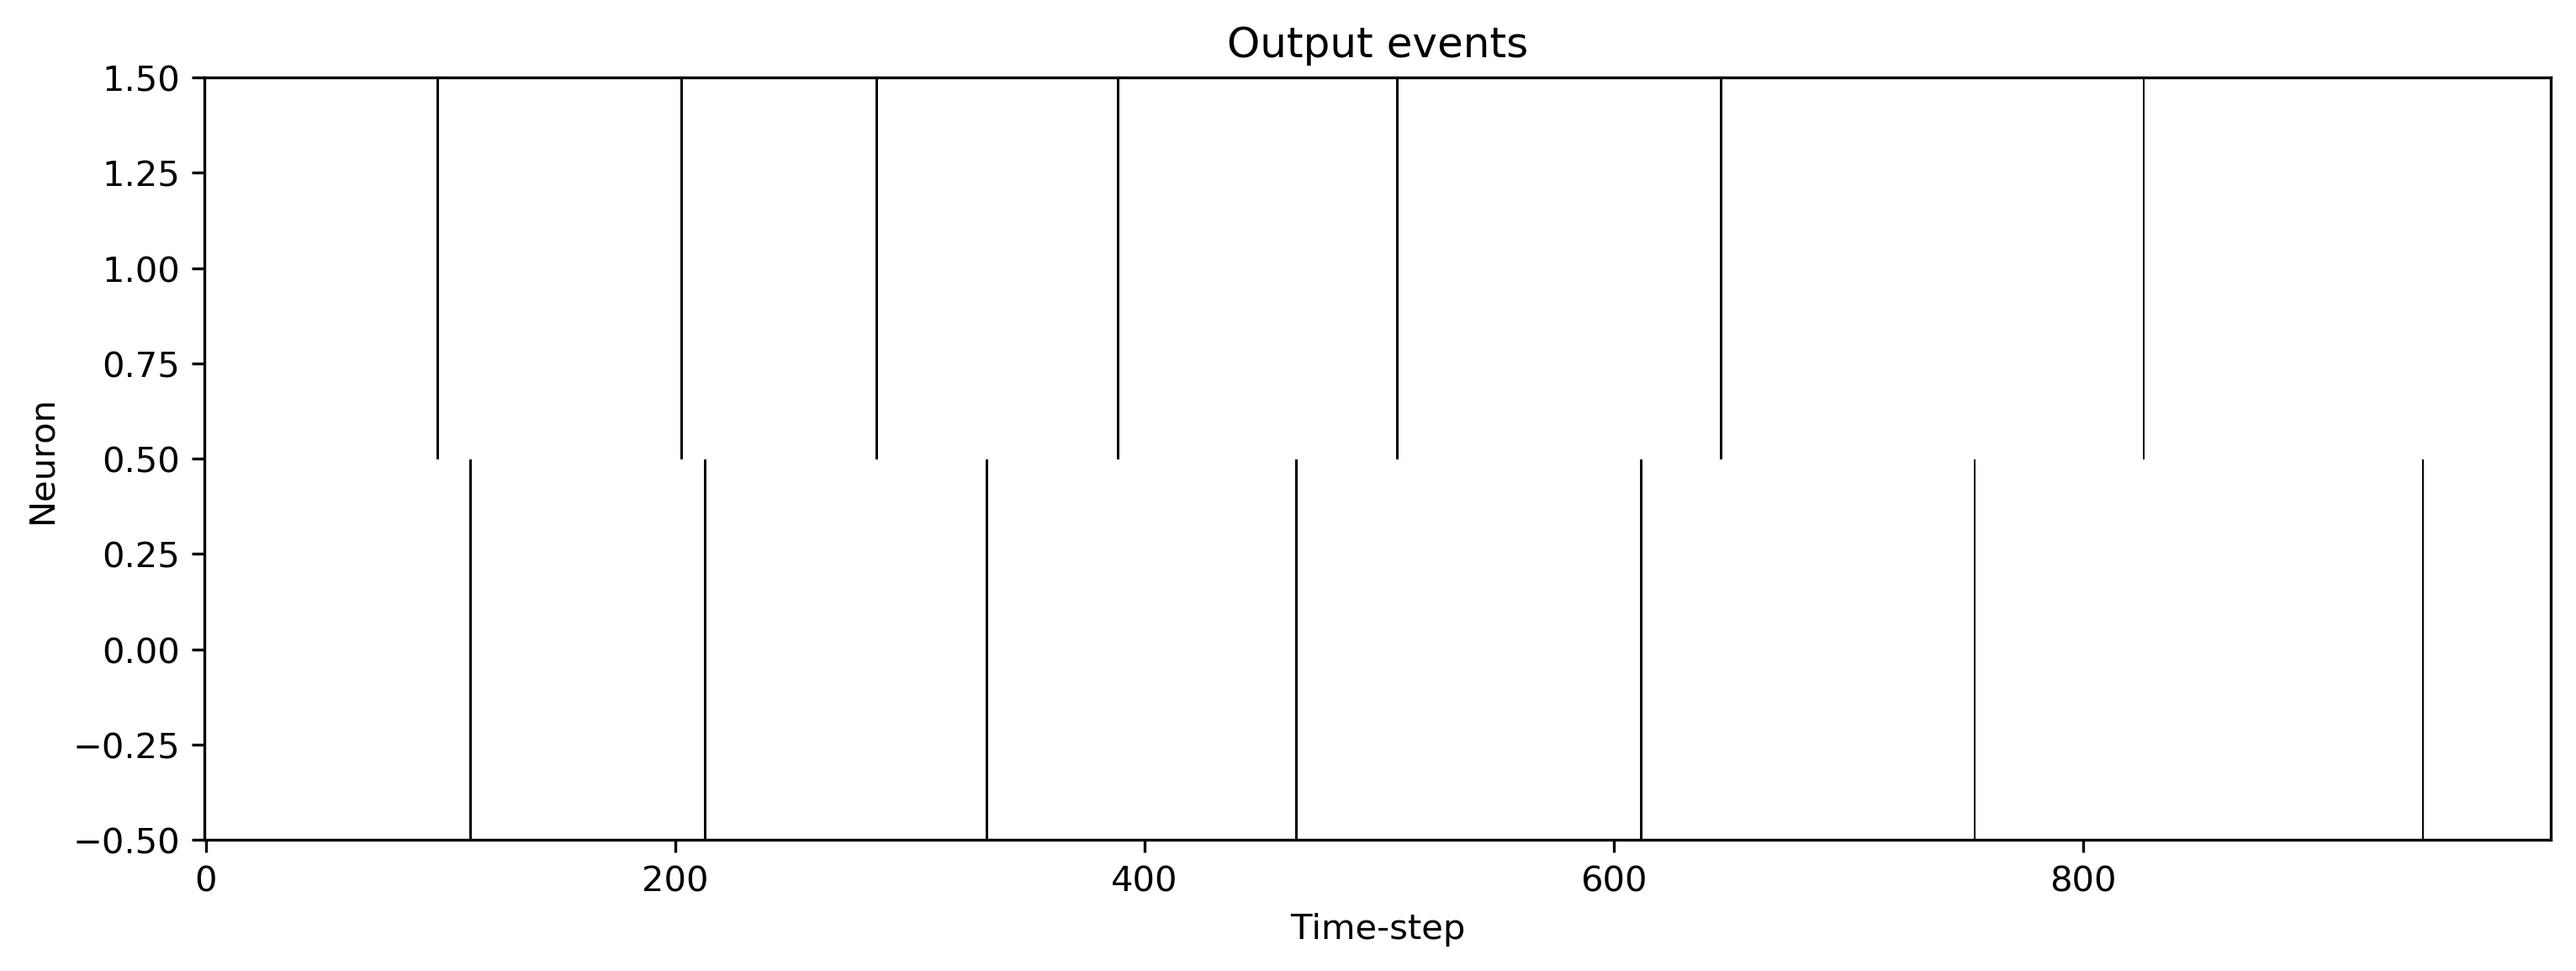

In [129]:
# - PLot the internal state and output
plt.plot(vs[0]);
plt.xlabel('Time-step')
plt.ylabel('$v$')
plt.title('Neuron state $v$')

plt.figure()
plt.imshow(ys[0].T, aspect='auto', origin='lower');
plt.xlabel('Time-step')
plt.ylabel('Neuron')
plt.title('Output events');

## Explicitly including time

From the update equations above we can start to make the temporal dependence of the neuron explicit, by defining what a time-step means, and by including a time constant of integration to define the neuron as an ODE.

$$\frac{\textrm{d}v}{\textrm{d}t} = (Wx + b) / \tau$$

We then rewrite the update equations to solve this ODE, as follows:

$$\dot{v} = Wx + b$$
$$v_{t+1} = v_t + \dot{v} \cdot \textrm{d}t / \tau$$

In [130]:
# - Define a forward function for an IAF spiking neuron
#   Arguments:
#   x - Input (Nbatches, Nsamples, Nin)
#   W - Weights (Nin, Nout)
#   b - Bias vector (Nout,)
#   theta - Threshold ()
#   tau - Time constant in seconds
#   dt - Time step in seconds
def forward_iaf_ode(x, W, b, theta, tau, dt):
    # - Here we obtain the shapes of the IAF layer and input
    Nbatches, Nsamples, Nin = x.shape
    _, Nout = W.shape
    
    # - Initialise the internal state record of the layer (Nout, )
    v = torch.zeros((Nout,))
    
    # - Initialise the output tensors to return
    vs = torch.empty(Nbatches, Nsamples, Nout)
    ys = torch.empty(Nbatches, Nsamples, Nout)
    
    # - Define the transfer function
    def H(v, theta):
        return v > theta
    
    # - Loop over time-steps
    for t in range(Nsamples):
        # - Compute dv
        dv = x[:, t, :] @ W + b
        
        # - Solve the ODE for v (Euler solver)
        v = v + dv * dt / tau
        
        # - Determine output by using transfer function H()
        y = H(v, theta)
        
        # - Reset spiking neurons
        v = v - y * theta
        
        # - Record state and output to return
        vs[:, t, :] = v
        ys[:, t, :] = y
        
    # - Return output
    return ys, vs    

In [150]:
# - Define layer size and parameters
Nin = 8
Nout = 2

W = torch.rand((Nin, Nout)) / np.sqrt(Nin)
b = 0.001 * torch.ones((Nout,))
theta = 1.

# - Define some random input
Nbatches = 1
Nsamples = 5000
spike_rate = 0.01
dt = 1e-3

input_spikes = (torch.rand((Nbatches, Nsamples, Nin)) < spike_rate).float()

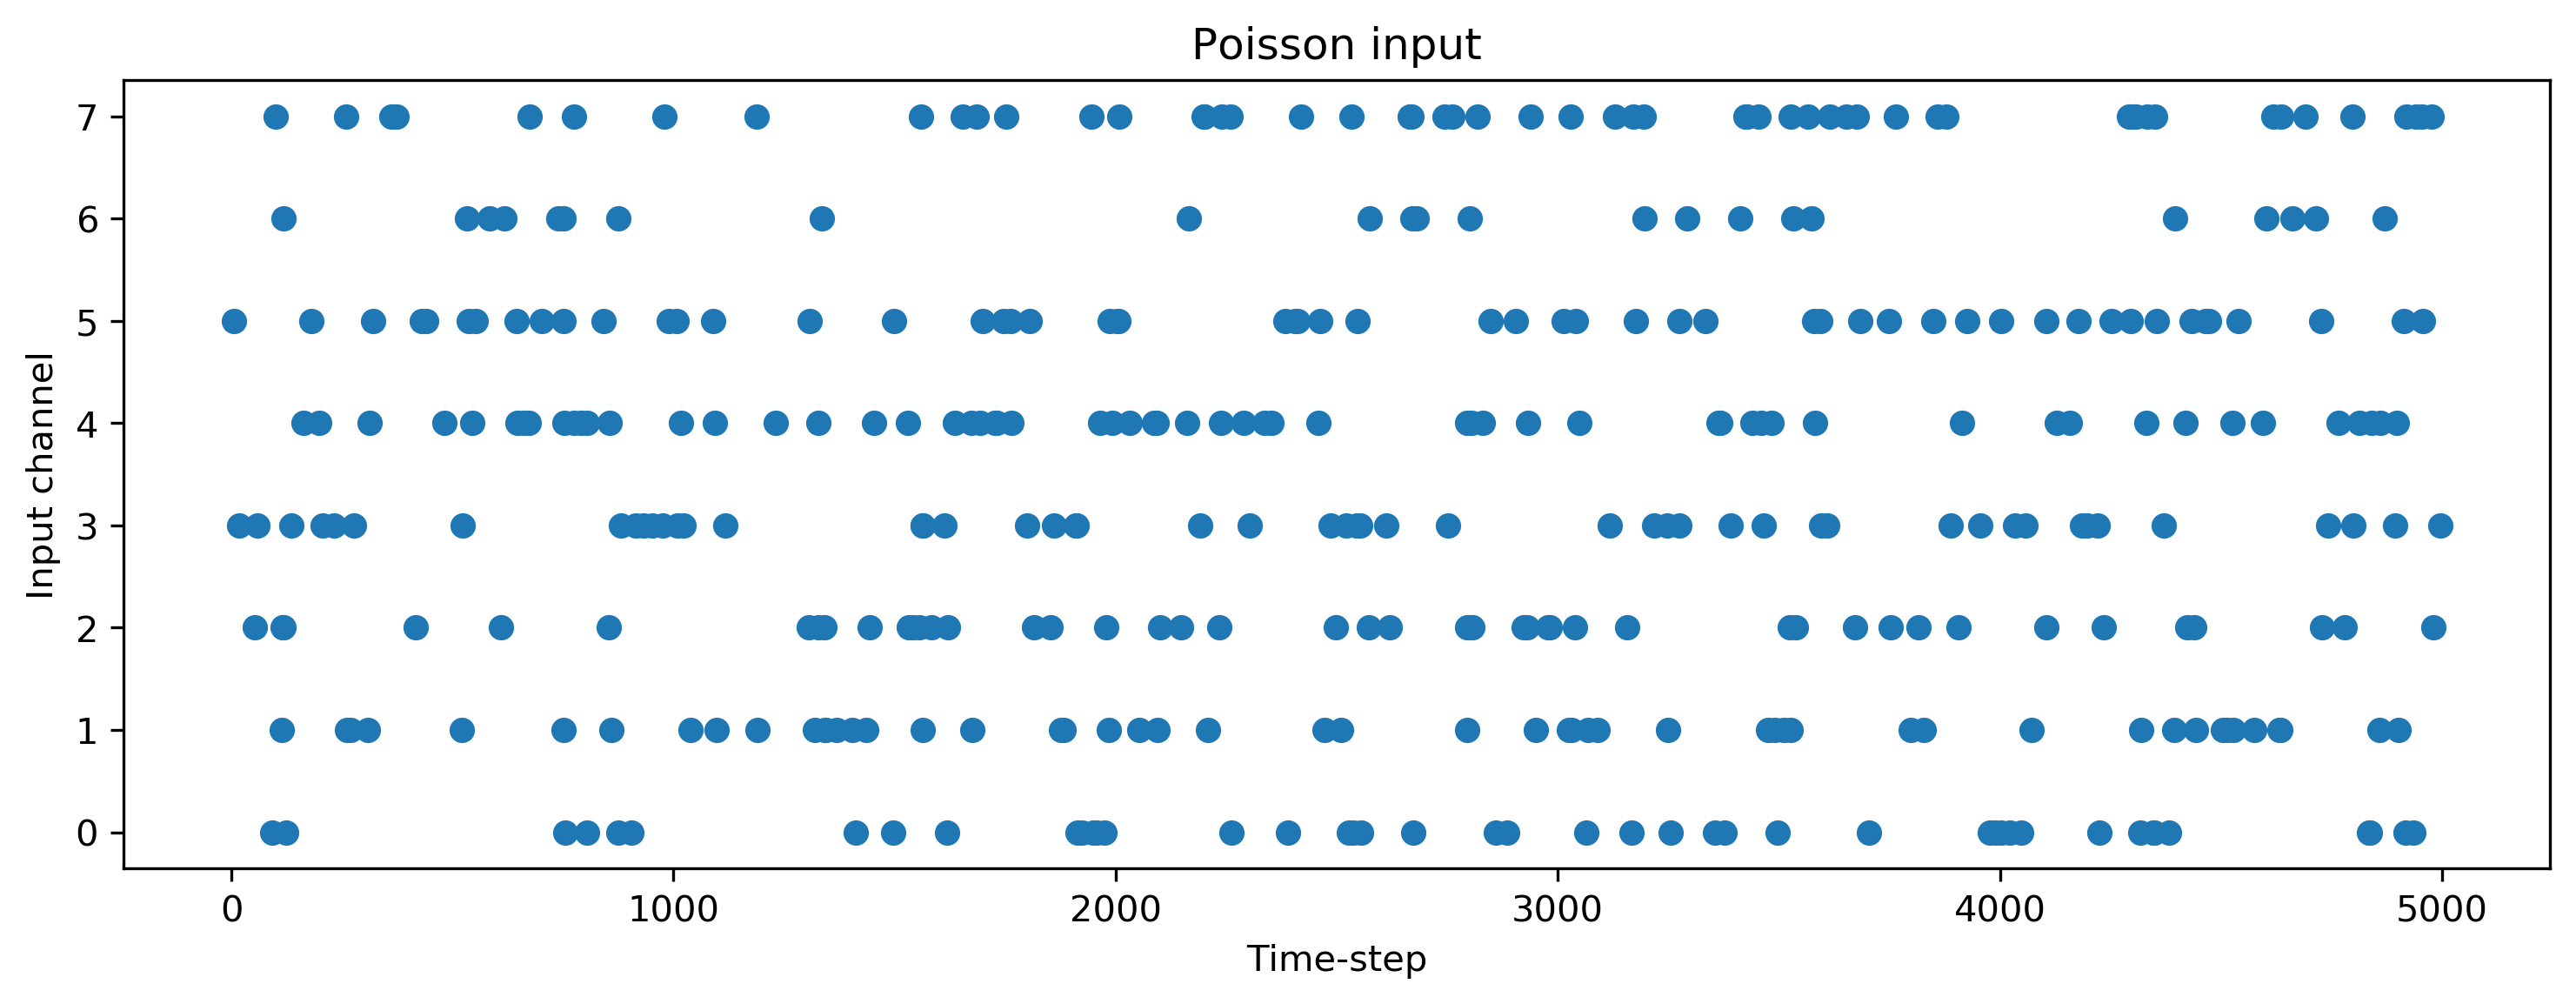

In [151]:
# plt.imshow(input_spikes[0].T, aspect = 'auto', origin = 'lower');
channel, time = np.where(input_spikes[0])
plt.scatter(channel, time)
plt.xlabel('Time-step')
plt.ylabel('Input channel')
plt.title('Poisson input');

In [152]:
# - Evaluate the spiking neuron over the input
tau = 10e-3
dt = 1e-3
ys, vs = forward_iaf_ode(input_spikes, W, b, theta, tau, dt)

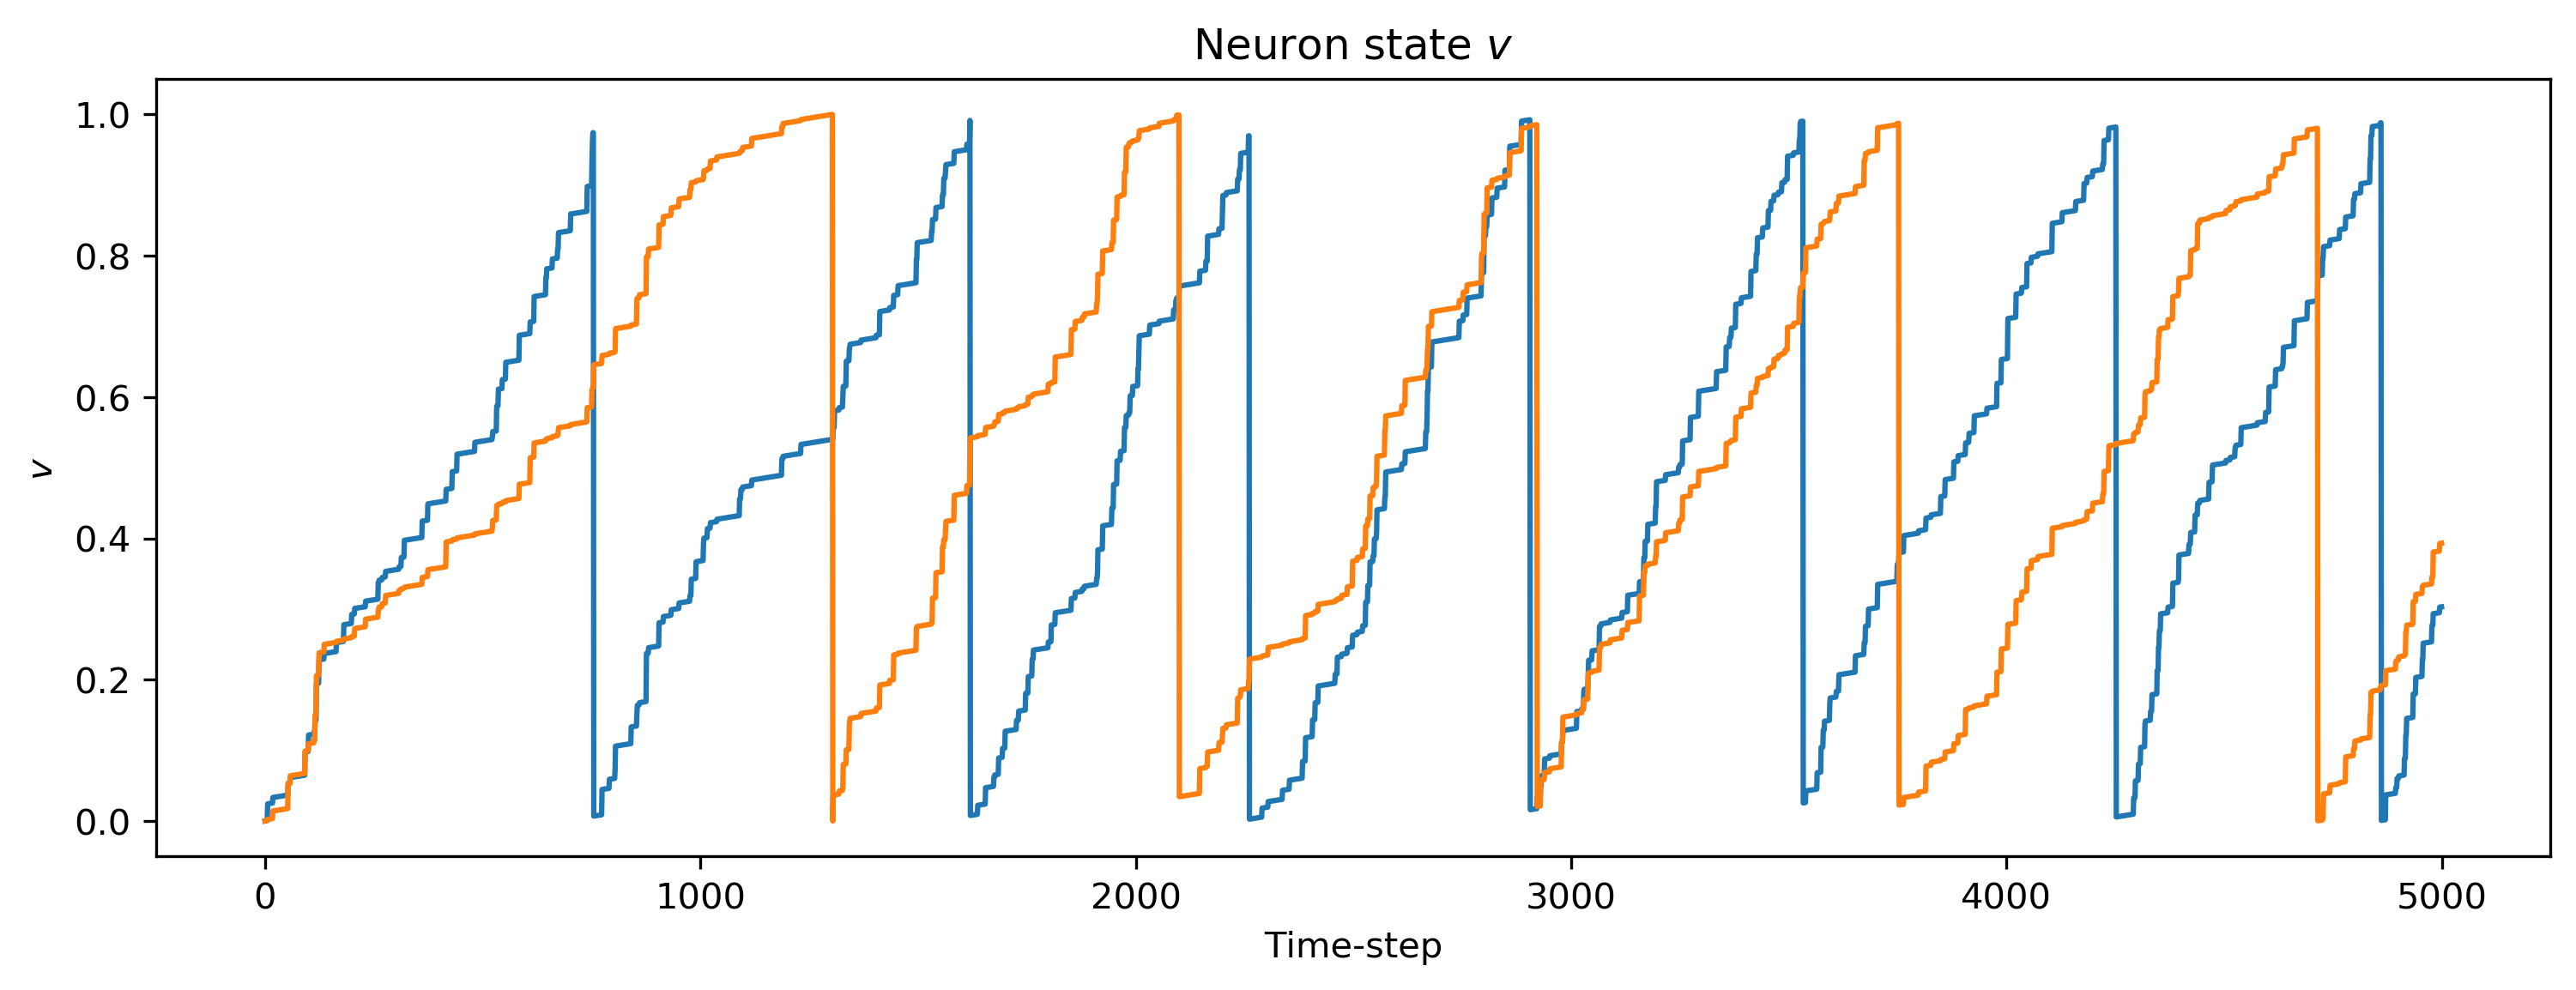

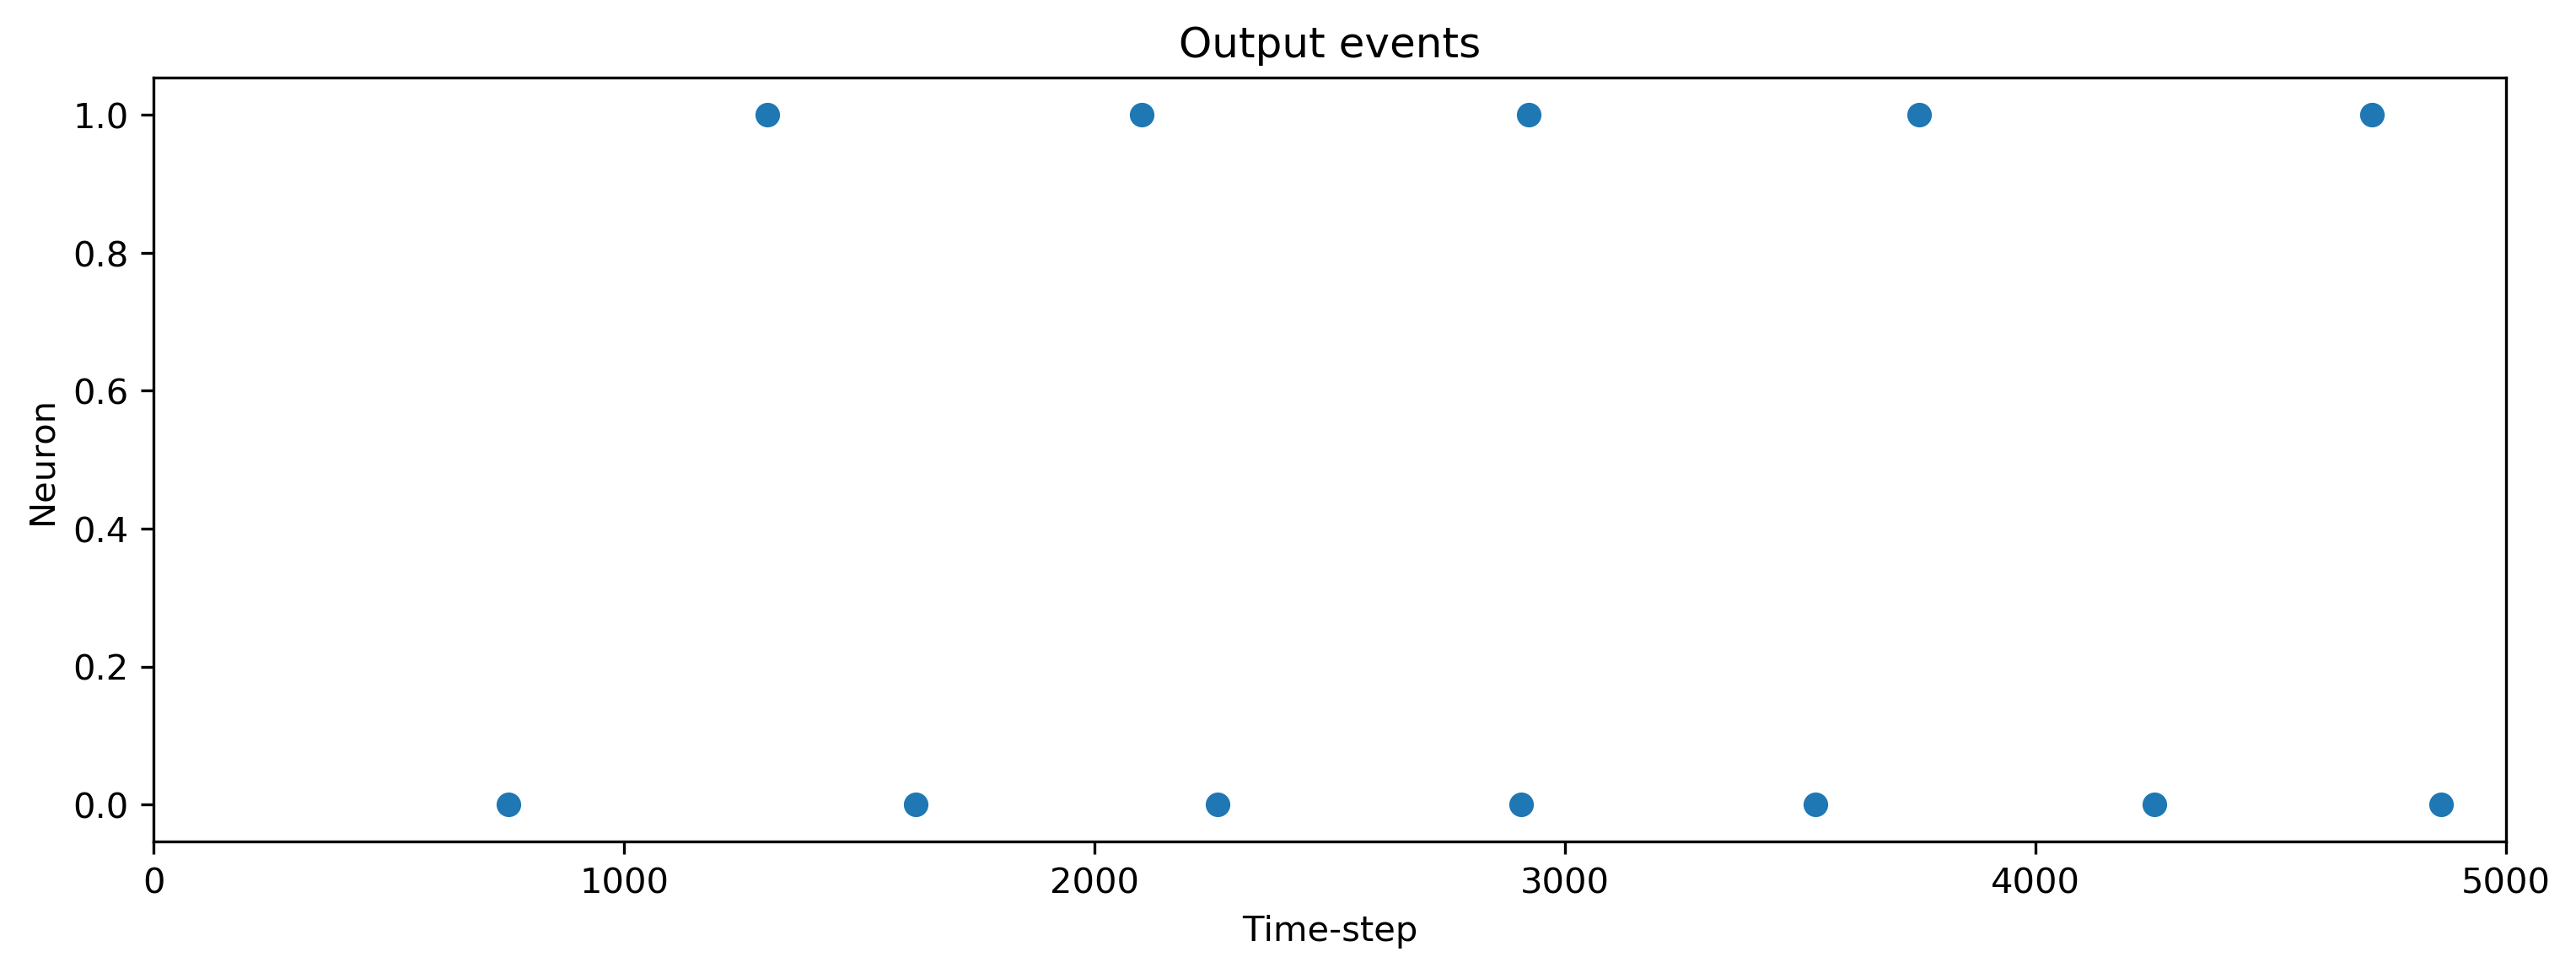

In [153]:
# - PLot the internal state and output
plt.plot(vs[0]);
plt.xlabel('Time-step')
plt.ylabel('$v$')
plt.title('Neuron state $v$')

plt.figure()
# plt.imshow(ys[0].T, aspect='auto', origin='lower');
channel, time = np.where(ys[0])
plt.scatter(channel, time)
plt.xlim([0, Nsamples])
plt.xlabel('Time-step')
plt.ylabel('Neuron')
plt.title('Output events');

The LIF model describes a dynamical system where $V$ is continually being updated. While this is a realistic description of most systems in the real world, for the sake of simplicity (and ease of computation on a digital system like a PC), if we assume that there is no leak in its membrane potential, such a model will hence forth be referred to as an *IAF* model, and can be described by the following equation:

$\tau \dot{V_m} = (I_{syn} + I_{bias})$

The benefit to removing the leak is that the dynamics are simplified, and implementing this neuron in hardware is more efficient: no multiplications are needed for decaying $V_m$.

In [141]:
import importlib

if importlib.util.find_spec('sinabs') is None:
    !pip install sinabs

In [142]:
## IAF model in SINABS
import torch
import sinabs.layers as sl

# Define a neuron in 'SINABS'
neuron = sl.SpikingLinearLayer(in_features=1, out_features=1, bias = True, threshold=1.0)

# Set a constant bias current to excite the neuron
neuron.linear.bias.data[:] = 0.025
neuron.linear.weight.data[:] = 0.1

# Define a two dimensional input spike vector of shape (Time, Neurons)
inp = torch.from_numpy(spikes).float().unsqueeze(-1)

# Membrane potential trace
V_m_t = [0]

# Output spike raster
spikes_t = [] # Spike train

for t in range(T):
    with torch.no_grad():
        # Simulate the IAF neuron using SINABS
        out = neuron(inp[t:t+1])
        
        # Check if there is a spike
        if (out!=0).any():
            spikes_t.append(t)
            
        # Record membrane potential
        V_m_t.append(neuron.state[0])

NameError: name 'spikes' is not defined

In [ ]:
# Plot membrane potential
plt.figure()
plt.plot(spikes_t, np.zeros(len(spikes_t)), '.')
plt.plot(range(T+1), V_m_t)
plt.title('IAF membrame dynamics')
plt.xlabel('Time (ms)')
plt.legend(['Output spikes', 'Membrane potential $V_m$'])
plt.ylabel('$V_m$');

## Activation function of a Spiking Neuron

The activation of an artificial neuron and that of a spiking neuron differ in one critical aspect: **the dependence on time.** So if we can interpret the response of a spiking neuron in a time independent manner, that gives us a proxy to a artificial neuron and therefore can build networks equivalent to ANNs.

One way to interpret the response of a spiking neuron to its inputs, is to look at the number of spikes the neuron produces within a time window. For instance, in the example above we can say that the neuron produces an output of $3$ for the given set of parameters and inputs. 

We will refer to this interpretetion of spikes as **rate coding** because we are looking at the spiking rate of neurons as our information medium.

With this rate coding interpretation of spiking neurons, let us look at what the transfer function $\Phi$ looks like for the IAF neuron model.

In [ ]:
# IAF neuron activation function
import numpy as np

# Define a neuron in 'SINABS'
neuron = sl.SpikingLinearLayer(in_features=1, out_features=1, bias = True, threshold=1.0)

# Define input spike vector with no spikes
t_sim = 100
inp = torch.zeros(t_sim, 1)

spike_rates_out = []

biases = np.arange(-5, 5, 0.2) # Range of inputs to iterate over

for bias in biases:
    # Reset the neuron
    neuron.reset_states()
    # Set a constant bias current to excite the neuron
    neuron.linear.bias.data[:] = bias
    # Output spike raster
    with torch.no_grad():
        # Simulate neuron for t_sim timesteps
        out = neuron(inp)
        """
        Notice that we can do the entire simulation in one line,
        unlike the code block earlier where we had a for loop to iterate over all time steps.
        """
        spike_rates_out.append(out.sum())

plt.figure()
plt.plot(biases, spike_rates_out)
plt.title("IAF neuron activation function $\Phi$")
plt.ylabel("Output spike count")
_ = plt.xlabel("Input current")

## IAF neuron's transfer function is equivalent to ReLU

The above figure must look familiar if you have worked with ANNs, especially deep learning models; the activation function of a `IAF neuron` can be interpreted as that of a `Rectified Linear Unit (ReLU)`'s activation function.

__This observation is the entry point to porting Deep Learning (DL) models consisting of layers with ReLU (which is a majority) activations to SNNs.__

## Integrate-and-fire model

Now we 


v = v + x @ W + b
y = v > th
s = s - th * y



In [ ]:
def forward_iaf(x, W, b, th = 10.):
    # - Work out the number of time-steps and size of the layer
    n_batches, n_samples, Nin = x.shape
    _, Nout = W.shape
    
    # - Initialise the internal state of the layer
    v = torch.zeros(n_batches, Nout)
    
    # - Initialise the tensors to return
    ys = torch.empty(n_batches, n_samples, Nout)
    vs = torch.empty(n_batches, n_samples, Nout)
    
    # - Loop over the samples and compute the neuron activation
    for t in range(n_samples):
        # - Accumulate the input from this time-step into the neuron state
        v = v + x[:, t, :] @ W + b
        
        # - Determine whether the neuron will emit a spike event this time-step
        ys[:, t, :] = (v > th).float()
        
        # - Update the state by subtracting the threshold from spiking neurons
        v = v - th * ys[:, t, :]
        
        # - Keep a record of the internal state
        vs[:, t, :] = v

    return ys, vs

In [ ]:
ys, vs = forward_iaf(input_data, W, b)

In [ ]:
plt.imshow(ys[0].T, aspect = 'auto', origin='lower');
plt.xlim([0, n_samples])
plt.xlabel('Timestep')
plt.ylabel('Output neuron')
plt.title('Spiking events')

plt.figure()
plt.plot(vs[0])
plt.plot([0, n_samples], [10., 10.], 'k:')
plt.xlim([0, n_samples])
plt.xlabel('Timestep')
plt.ylabel('Neuron state')
plt.title('Neuron state');

## Leaky Integrate and Fire (LIF) model

<div>
    <img src="https://raw.githubusercontent.com/ai-cortex/snn-workshop-amld-2020/master/Notebooks/1_IntroToSNNs/LIF-neuron-full.png" width="50%" /><br />
    <i>Diagram of a simple spiking neuron. Inputs and outputs are series of event pulses called "spikes". The neuron implements temporal dynamics when integrating the input spikes, and when updating its internal state.</i>
</div>
<br />

### Internal state — "membrane potential"
One of the simplest models of spiking neurons is the Leaky Integrate and Fire (LIF) neuron model, where the state of the neuron, known as the *membrane potential* $V_m(t)$, depends on its previous state in addition to its inputs. The dynamics of this state can be described as follows:

$$\tau_m \cdot d{V_m}/dt = - V_m(t) + I_s(t) + b$$

where $\tau_m$ is the membrane time constant, which determines how much the neuron depends on its previous states and inputs and therefore defines the neuron's memory; and $b$ is a constant bias.

The linear equation above describes the dynamics of a system with "leaky" dynamics ie over time, the membrane potential $V$ slowly "leaks" to $0$. This is why the neuron model is referred to as a **Leaky Integrate and Fire Neuron model**.

Note that there is an explicit notion of time, which does not occur in the standard artificial neuron model above.

### Synaptic inputs
Spiking input is integrated onto the membrane of the neuron via a synaptic current $I_s(t)$, which has its own dynamics:

$\tau_s \cdot d{I}_s/dt + I_s(t) = \sum_i w_i \cdot \sum_j \delta(t-t_j^{i})$

where $\sum_j \delta(t-t_j^i)$ is a stream of spikes from presynaptic neuron $i$ occurring at times $t_j^i$. The values $w_i$ represent the corresponding weights. The synaptic currents decay towards zero under the synaptic time constant $\tau_s$.

Let's simulate the synapse and membrane dynamics with a random spike train input, and see how they evolve. First we will generate a random ("Poisson") spike train, by thresholding random noise.

In [ ]:
# - Import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]

In [ ]:
# - Generate a random spike train
T = 100
spike_prob = 0.1
spikes = np.random.rand(T,) < spike_prob

# - Plot the spike train
plt.figure()
plt.stem(spikes, use_line_collection=True)
plt.xlabel('Time (ms)')
plt.title('Random spikes');

Below we implement the synaptic and membrane dynamics by iterating over time, and computing the synapse and membrane values in the simplest possible way. 

In [ ]:
# - A simple Euler solver for the synapse and membrane. One time step is 1 ms

tau_m = 10 # ms
tau_s = 10 # ms
V_m = 0 # Initial membrane potential
I_s = 0 # Initial synaptic current
I_bias = 0 # Bias current

V_m_t = []
I_s_t = []

# - Loop over time and solve the synapse and membrane dynamics
for t in range(T):
    # Take account of input spikes
    I_s = I_s + spikes[t]

    # Integrate synapse dynamics
    dI_s = -I_s / tau_s
    I_s = I_s + dI_s
    
    # Integrate membrane dynamics
    dV_m = (-V_m + I_s) / tau_m
    V_m = V_m + dV_m
    
    # Save data
    V_m_t.append(V_m)
    I_s_t.append(I_s)

In [ ]:
plt.figure()
spike_times = np.argwhere(spikes)
plt.plot(spike_times, np.zeros(len(spike_times)), '.')
plt.plot(I_s_t)
plt.xlabel('Time (ms)')
plt.ylabel('$I_s$')
plt.title('Synaptic current $I_s$')
plt.legend(['Input spikes', 'Synaptic current'])

plt.figure()
plt.plot(spike_times, np.zeros(len(spike_times)), '.')
plt.plot(V_m_t, c='purple')
plt.xlabel('Time (ms)')
plt.ylabel('$v_m$')
plt.legend(['Input spikes', 'Membrane potential'])
plt.title('Membrane potential $V_m$');

### Spiking neuron output
The output of the LIF neuron is binary and instantaneous. It is $1$ only when $V$ reaches a threshold value $V_{th}=1$, upon which the membrane potential is immediately reset by subtracting one.

$
V_m(t+\delta) = 
\begin{cases}
V_m - V_{th},& \text{if } V(t) \geq V_{th} \\ 
V(t),& \text{otherwise} 
\end{cases}
$


This instantanious output of $1$ is typically referred to as a "spike" at time $t$. A series of such spikes will hence forth be referred to as $s(t)$.

$
s(t) = 
\begin{cases}
1,& \text{if } V_m(t)\geq V_{th}\\
0,& \text{otherwise}
\end{cases}
$

We can include spike generation and reset into the LIF simulation:

In [ ]:
# - A simple Euler solver for the synapse and membrane, including spike generation. One time step is 1 ms

tau_m = 10 # ms
tau_s = 10 # ms
V_m = 0 # Initial membrane potential
V_th = 1 # Spiking threshold potential
I_s = 0 # Initial synaptic current
I_bias = 0 # Bias current

V_m_t = []
I_s_t = []
spikes_t = []

# - Loop over time and solve the synapse and membrane dynamics
for t in range(T):
    # Take account of input spikes
    I_s = I_s + spikes[t]

    # Integrate synapse dynamics
    dI_s = -I_s / tau_s
    I_s = I_s + dI_s
    
    # Integrate membrane dynamics
    dV_m = (1/tau_m)*(-V_m + I_s)
    V_m = V_m + dV_m
    
    # - Spike detection
    if V_m > V_th:
        # - Reset
        V_m = V_m - 1
        
        # - Save the spike time
        spikes_t.append(t)
    
    # Save data
    V_m_t.append(V_m)
    I_s_t.append(I_s)

In [ ]:
plt.figure()
plt.plot(spikes_t, np.zeros(len(spikes_t)), '.')
plt.plot(V_m_t, c='purple')
plt.plot([0, T], [V_th, V_th], 'k:')
plt.xlabel('Time (ms)')
plt.ylabel('$v_m$')
plt.legend(['Output spikes', 'Membrane potential', 'Spiking threshold'])
plt.title('Membrane potential $V_m$');

## References

- Vreeken, Jilles. (2003). Spiking Neural Networks, an Introduction.

- Farabet C, Paz R, Pérez-Carrasco J, Zamarreño C, Linares-Barranco A, LeCun Y, Culurciello E, Serrano-Gotarredona T, Linares-Barranco B. Comparison between frame-constrained fix-pixel-value and frame-free spiking-dynamic-pixel convNets for visual processing. Frontiers in neuroscience. 2012 Apr 12;6:32.
- Neil D, Pfeiffer M, Liu SC. Learning to be efficient: Algorithms for training low-latency, low-compute deep spiking neural networks. InProceedings of the 31st annual ACM symposium on applied computing 2016 Apr 4 (pp. 293-298). ACM.
- Rueckauer B, Lungu IA, Hu Y, Pfeiffer M, Liu SC. Conversion of continuous-valued deep networks to efficient event-driven networks for image classification. Frontiers in neuroscience. 2017 Dec 7;11:682.
- Sengupta A, Ye Y, Wang R, Liu C, Roy K. Going deeper in spiking neural networks: VGG and residual architectures. Frontiers in neuroscience. 2019;13.